In [1]:
%matplotlib inline

import matplotlib
from matplotlib import dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import cmocean.cm as cmo

#plt.style.use('ggplot')
plt.style.use('seaborn-poster')

In [2]:
omega_name = 'test'
df = xr.open_dataset(f'wind_shear_{omega_name}.nc')

In [3]:
df

<xarray.Dataset>
Dimensions:  (time: 101, xC: 16, xF: 16, yC: 16, yF: 16, zC: 16, zF: 17)
Coordinates:
  * zC       (zC) float64 -15.5 -14.5 -13.5 -12.5 -11.5 ... -3.5 -2.5 -1.5 -0.5
  * zF       (zF) float64 -16.0 -15.0 -14.0 -13.0 -12.0 ... -3.0 -2.0 -1.0 0.0
  * xC       (xC) float64 1.25 3.75 6.25 8.75 11.25 ... 31.25 33.75 36.25 38.75
  * yF       (yF) float64 0.0 2.5 5.0 7.5 10.0 12.5 ... 27.5 30.0 32.5 35.0 37.5
  * xF       (xF) float64 0.0 2.5 5.0 7.5 10.0 12.5 ... 27.5 30.0 32.5 35.0 37.5
  * yC       (yC) float64 1.25 3.75 6.25 8.75 11.25 ... 31.25 33.75 36.25 38.75
  * time     (time) float64 0.0 629.7 1.258e+03 ... 6.221e+04 6.284e+04
Data variables:
    v        (time, zC, yF, xC) float64 ...
    S        (time, zC, yC, xC) float64 ...
    w        (time, zF, yC, xC) float64 ...
    T        (time, zC, yC, xC) float64 ...
    u        (time, zC, yC, xF) float64 ...
Attributes:
    f:        0.0001
    g:        9.80665
    alpha:    0.0002
    beta:     0.0008

In [4]:
Tme = np.nanmean(df.T.values, axis=(2,3))
Tvar = np.nanvar(df.T.values, axis=(2,3))
#Sme = np.nanmean(df.S.values, axis=(2,3))

In [5]:
ume = np.nanmean(df.u.values, axis=(2,3))
vme = np.nanmean(df.v.values, axis=(2,3))
wvar = np.nanvar(df.w.values, axis=(2,3))

In [6]:
g_earth = 9.80665
f = df.f
Ti = 2*np.pi/f

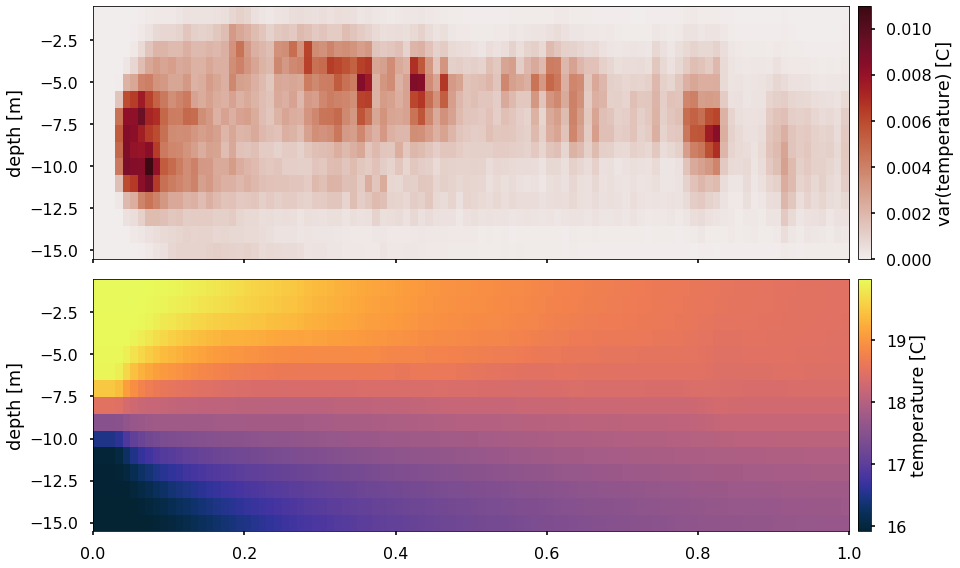

In [7]:
fig, (ax,ax1) = plt.subplots(ncols=1, nrows=2, figsize=(14,8), sharex=True)
im = ax.pcolor(df.time.values/Ti, df.zC, Tvar.T, cmap=cmo.amp)
cb = plt.colorbar(im, ax=ax, pad=0.01, label='var(temperature) [C]')
ax.set_ylabel('depth [m]')

im1 = ax1.pcolor(df.time.values/Ti, df.zC, Tme.T, cmap=cmo.thermal)
cb1 = plt.colorbar(im1, ax=ax1, pad=0.01, label='temperature [C]')
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(15))
#ax.xaxis.set_major_formatter(hfmt)
ax1.set_ylabel('depth [m]')

plt.tight_layout()
plt.show()

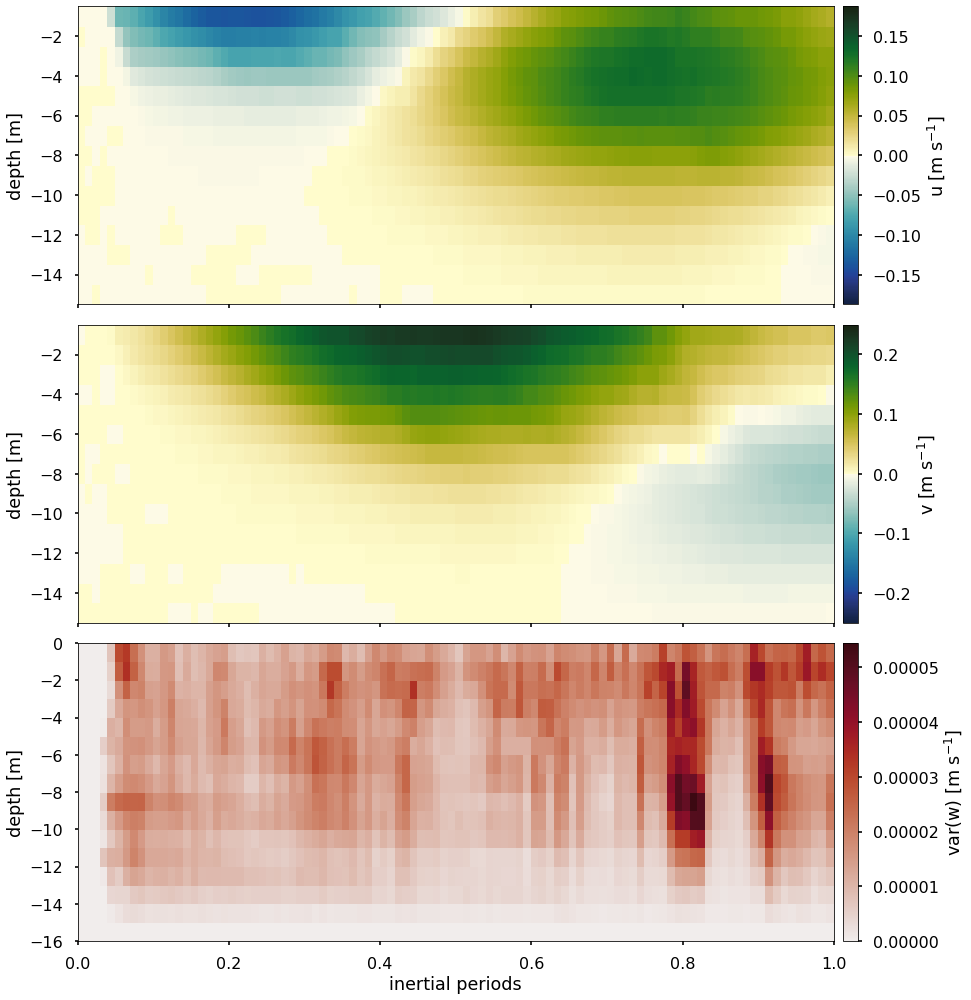

In [8]:
fig, (ax0,ax1,ax2) = plt.subplots(ncols=1, nrows=3, figsize=(14,14), sharex=True)
vmax = np.max(np.abs(ume))
im = ax0.pcolor(df.time.values/Ti, df.zC, ume.T, cmap=cmo.delta, vmax=vmax, vmin=-vmax)
cb = plt.colorbar(im, ax=ax0, pad=0.01, label='u [m s$^{-1}$]')
ax0.set_ylabel('depth [m]')

vmax = np.max(np.abs(vme))
im = ax1.pcolor(df.time.values/Ti, df.zC, vme.T, cmap=cmo.delta, vmax=vmax, vmin=-vmax)
cb = plt.colorbar(im, ax=ax1, pad=0.01, label='v [m s$^{-1}$]')
ax1.set_ylabel('depth [m]')

im = ax2.pcolor(df.time.values/Ti, df.zF, wvar.T, cmap=cmo.amp)
cb = plt.colorbar(im, ax=ax2, pad=0.01, label='var(w) [m s$^{-1}$]')
ax2.set_ylabel('depth [m]')
ax2.set_xlabel('inertial periods')

plt.tight_layout()
plt.show()

In [9]:
dz_cell = np.mean(np.gradient(df.zC))
dz_face = np.mean(np.gradient(df.zF))

In [10]:
def linear_equation_of_state(temp_array, salt_array):
    alpha = 2e-4
    beta  = 8e-4 
    return alpha * (temp_array-np.mean(temp_array)) - beta * (salt_array-np.mean(salt_array))

b = g_earth*linear_equation_of_state(df.T.values, df.S.values)

In [11]:
N2    = np.gradient(b, axis=(1))/dz_cell
N2me  = np.nanmean(N2, axis=(2,3))
N2var = np.nanvar(N2, axis=(2,3))

S2    = (np.gradient(df.u, axis=(1))/dz_cell)**2 + (np.gradient(df.v, axis=(1))/dz_cell)**2
S2me  = np.nanmean(S2, axis=(2,3))
S2var = np.nanvar(S2, axis=(2,3))

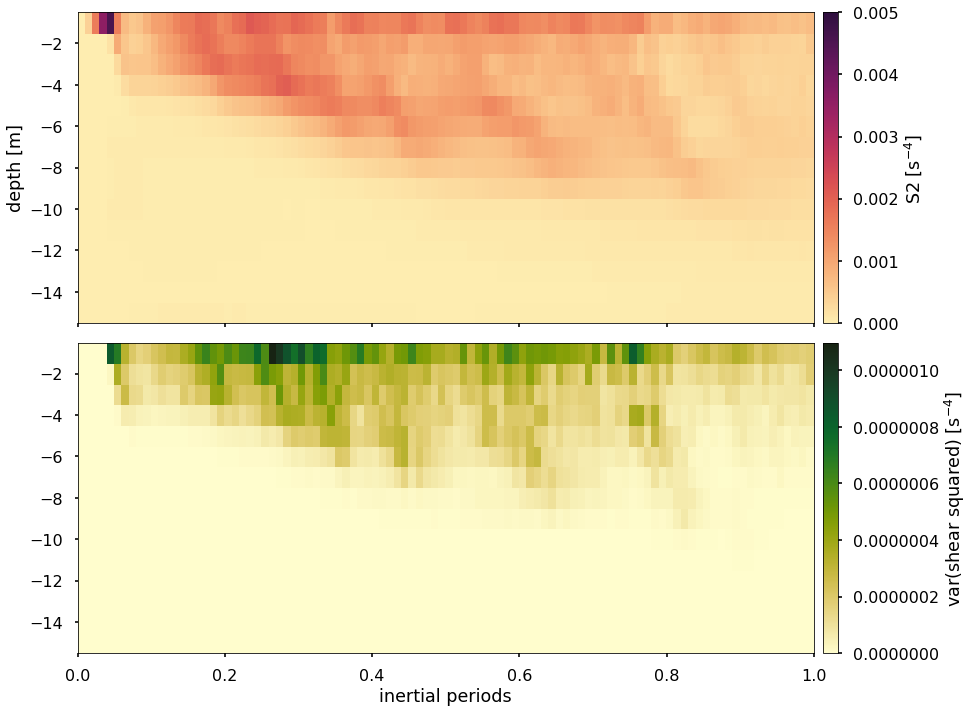

In [12]:
fig, (ax,ax1) = plt.subplots(ncols=1, nrows=2, figsize=(14,10), sharex=True)
im = ax.pcolor(df.time.values/Ti, df.zC, S2me.T, cmap=cmo.matter, vmax=0.005)
cb = plt.colorbar(im, ax=ax, pad=0.01, label='S2 [s$^{-4}$]')
ax.set_ylabel('depth [m]')

im = ax1.pcolor(df.time.values/Ti, df.zC, S2var.T, cmap=cmo.speed)
cb = plt.colorbar(im, ax=ax1, pad=0.01, label='var(shear squared) [s$^{-4}$]')
ax.set_ylabel('depth [m]')
ax1.set_xlabel('inertial periods')

plt.tight_layout()
plt.show()

In [13]:
reduced_shear = S2 - 4*N2
reduced_shearme = np.nanmean(reduced_shear, axis=(2,3))
reduced_shearvar = np.nanvar(reduced_shear, axis=(2,3))

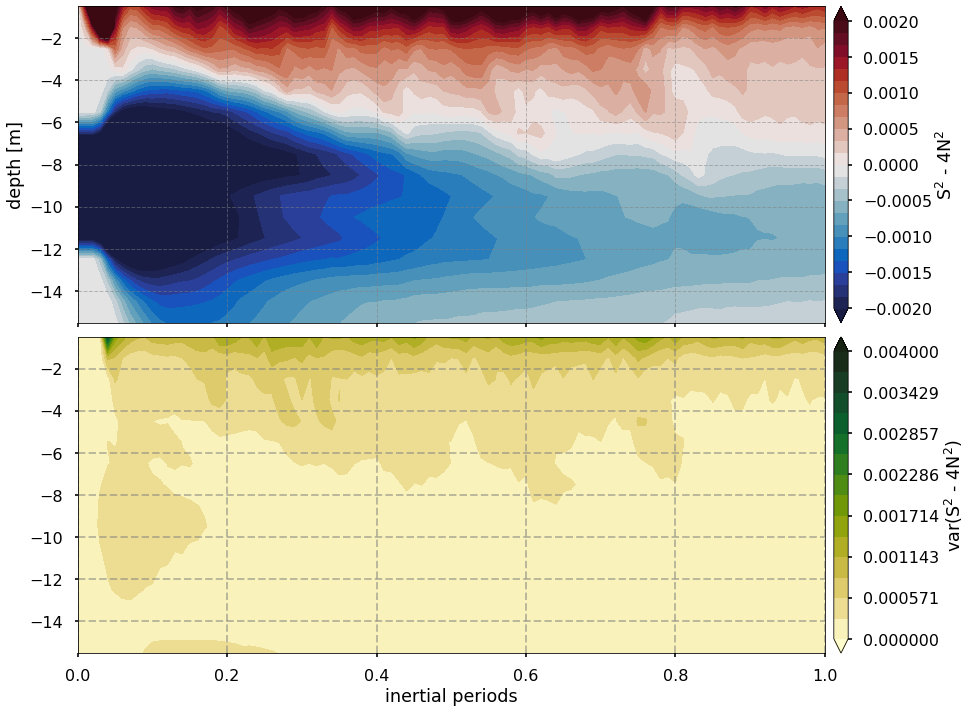

In [14]:
fig, (ax,ax1) = plt.subplots(ncols=1, nrows=2, figsize=(14,10), sharex=True)
var = reduced_shearme.T
level_max = 2e-3
level2 = np.linspace(-level_max,level_max,25)
#vmax = 0.005 #np.max(np.abs(var))
im = ax.contourf(df.time.values/Ti, df.zC, var, cmap=cmo.balance, levels=level2, extend='both')
cb = plt.colorbar(im, ax=ax, pad=0.01, label='S$^2$ - 4N$^2$')
ax.grid(linewidth=1, linestyle="--", alpha=0.5, c='gray')
ax.set_ylabel('depth [m]')

var = np.sqrt(reduced_shearvar.T)
level_max = 4e-3
level2 = np.linspace(0,level_max,15)
im = ax1.contourf(df.time.values/Ti, df.zC, var, cmap=cmo.speed, levels=level2, extend='both')
cb = plt.colorbar(im, ax=ax1, pad=0.01, label='var(S$^2$ - 4N$^2$)')
ax.set_ylabel('depth [m]')
ax1.set_xlabel('inertial periods')
ax1.grid(linewidth=2, linestyle="--", alpha=0.5, c='gray')

plt.tight_layout()
plt.savefig('figures/{}_reducedshear.png'.format(omega_name), dpi=300, bbox_inches='tight')
plt.show()

In [15]:
bins = np.linspace(-0.005,0.005,1001)
bin_centers = (bins[:-1] + bins[1:]) / 2

In [16]:
def make_2d_hist_in_z(variable, time_step, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist, _ = np.histogram(variable[50,10,:,:], bins=bins)
    zlen = np.shape(variable)[1]
    blen = np.shape(bin_centers)[0]
    temp = np.ones((blen,zlen))
    for i in range(zlen):
        hist, _ = np.histogram(variable[time_step,i,:,:], bins=bins)
        temp[:,i] = hist/sum(hist)
    return bin_centers, temp

def probability_positive(variable, time_step):
    zlen = np.shape(variable)[1]
    temp = np.ones(zlen)
    for i in range(zlen):
        a = variable[time_step,i,:,:]
        q = np.reshape(a,(np.size(a)))
        testpos = q > 0
        temp[i] = len(q[testpos])/len(q)
    return temp

    
hist, _ = np.histogram(reduced_shear[50,10,:,:], bins=bins)

In [17]:
RS_pos = np.ones_like(reduced_shear[:,:,1,1])
for i in range(len(df.time)):
    RS_pos[i,:] = probability_positive(reduced_shear, i)

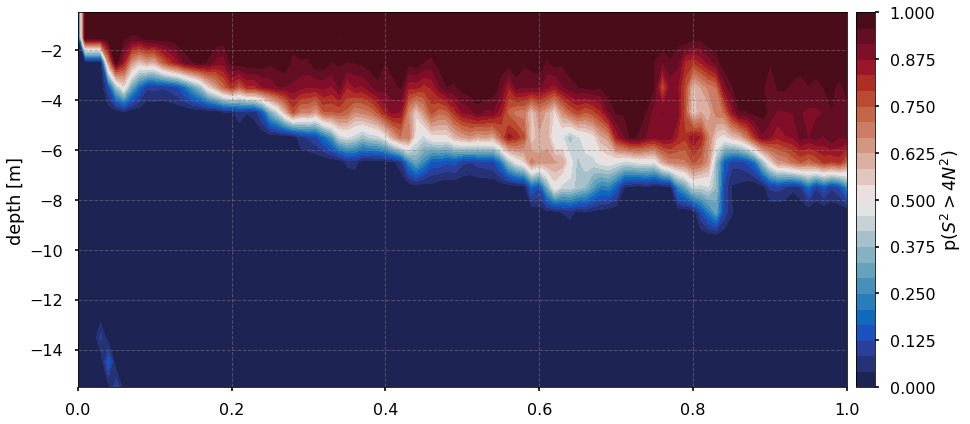

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,6))
var = RS_pos.T
level_max = 1
level2 = np.linspace(0,1,25)
#vmax = 0.005 #np.max(np.abs(var))
im = ax.contourf(df.time.values/Ti, df.zC, var, cmap=cmo.balance, levels=level2)
cb = plt.colorbar(im, ax=ax, pad=0.01, label='p($S^2 > 4N^2$)')
ax.grid(which='major', linewidth=1, linestyle="--", alpha=0.5, c='gray')
ax.set_ylabel('depth [m]')

plt.tight_layout()
plt.savefig('figures/{}_pRS_omega.png'.format(omega_name), dpi=300, bbox_inches='tight')
plt.show()